# 第一次作业

在2.1和2.2小节的基础上，探究网络层数、隐藏层神经元个数和激活函数对网络在MNIST数据集上的性能的影响。

1. 将网络层数调整为{1,2,3,4,5}，观察模型在训练集和测试集上的损失函数/准确率的变化。
1. 固定网络层数为2，将隐藏层神经元个数调整为{1,4,16,64}，观察模型在训练集和测试集上的损失函数/准确率的变化。
1. 固定网络层数为2，去掉网络中的激活函数，观察模型在训练集和测试集上的损失函数/准确率。
1. 对于上述的现象，我们能解释其发生的原因吗？

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

using device: cuda


In [ ]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# 下载MNIST数据集中的训练集，并保存到data文件夹
data_train = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
# 加载MNIST数据集中的测试集
data_test = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
def create_model(n_layers, in_features, out_features, n_hidden, activation=nn.ReLU()):
    model = []

    assert n_layers > 0, "num of layers should be larger than 0"

    if n_layers == 1:
        model.append(nn.Linear(in_features, out_features))
    else:
        model.append(nn.Linear(in_features, n_hidden))
        if activation is not None:
            model.append(activation)
        
        for i in range(n_layers-2):
            model.append(nn.Linear(n_hidden, n_hidden))

            if activation is not None:
                model.append(activation)
        
        model.append(nn.Linear(n_hidden, out_features))

    model = nn.Sequential(*model)

    return model

In [ ]:
@torch.no_grad() # 由于测试的时候不需要求导，可以暂时关闭autograd，提高速度，节约内存
def test(model, data, batch_size=128):
    num_correct = 0 # 预测正确的图片数
    num_total = 0 # 总共的图片数
    
    test_loader = torch.utils.data.DataLoader(data, 
                                              batch_size=batch_size, 
                                              shuffle=False)
    for data in test_loader: # 按batch取出测试集中的数据
        img, label = data
        img = img.view((img.shape[0], -1))
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        predicted = output.argmax(1)
        num_total += len(label)
        num_correct += (predicted == label).sum()

    # print('共有{}张图片，准确率为: {:.2f}%'.format(num_correct, 100 * num_correct / num_total))
    return (num_correct / num_total).item()

In [ ]:
# 我们定义一个train函数来封装我们的训练过程
def train(model, data, data_test, num_epochs=5, learning_rate=1e-3, batch_size=32):
    # 定义一个优化器，Adam优化器是梯度下降法的一个变种
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # weight_decay表示L2正则项
    
    # 把训练数据封装到DataLoader，这样便于我们以及选取batch以及打乱数据顺序
    train_loader = torch.utils.data.DataLoader(data, 
                                               batch_size=batch_size, 
                                               shuffle=True)
    # 定义损失函数
    criterion = nn.CrossEntropyLoss()

    hist = {"loss": [], "acc_train": [], "acc_test": []}
    
    for epoch in range(num_epochs):
        loss_total = 0 # 定义一个loss_total变量来记录我们的loss变化
        for data in train_loader:
            # 梯度清零
            optimizer.zero_grad()
            
            img, label = data
            img = img.view((img.shape[0], -1))
            img = img.to(device)
            label = label.to(device)
            
            # 前向传播和反向传播
            output = model(img)
            loss = criterion(output, label)
            loss.backward()
            
            # 优化参数
            optimizer.step()
        
        # training history
        loss_total += loss.item()
        acc_train= test(model, data_train, batch_size)
        acc_test = test(model, data_test, batch_size)

        hist["loss"].append(loss_total)
        hist["acc_train"].append(acc_train)
        hist["acc_test"].append(acc_test)
        
        print('Epoch: {}, Training Loss: {:.4f}, Training Accuracy: {:.4f}, Test Accuracy: {:.4f}'.format(epoch+1, loss_total, acc_train, acc_test))
    
    return hist

# Q1

In [ ]:
n_layers = [1, 2, 3, 4, 5]
hists = []

for n_layer in n_layers:
    model = create_model(n_layer, 784, 10, 64)
    model = model.to(device) 

    print(f"n_layer: {n_layer}")
    hist = train(model, data_train, data_test, num_epochs=10)
    hists.append(hist)
    
    print()

n_layer: 1
Epoch: 1, Training Loss: 0.4767, Training Accuracy: 0.9117, Test Accuracy: 0.9157
Epoch: 2, Training Loss: 0.2040, Training Accuracy: 0.9208, Test Accuracy: 0.9217
Epoch: 3, Training Loss: 0.1952, Training Accuracy: 0.9222, Test Accuracy: 0.9228
Epoch: 4, Training Loss: 0.3232, Training Accuracy: 0.9270, Test Accuracy: 0.9257
Epoch: 5, Training Loss: 0.2712, Training Accuracy: 0.9286, Test Accuracy: 0.9261
Epoch: 6, Training Loss: 0.1565, Training Accuracy: 0.9295, Test Accuracy: 0.9261
Epoch: 7, Training Loss: 0.3785, Training Accuracy: 0.9299, Test Accuracy: 0.9246
Epoch: 8, Training Loss: 0.1512, Training Accuracy: 0.9319, Test Accuracy: 0.9276
Epoch: 9, Training Loss: 0.2486, Training Accuracy: 0.9321, Test Accuracy: 0.9260
Epoch: 10, Training Loss: 0.1537, Training Accuracy: 0.9324, Test Accuracy: 0.9276

n_layer: 2
Epoch: 1, Training Loss: 0.0675, Training Accuracy: 0.9441, Test Accuracy: 0.9423
Epoch: 2, Training Loss: 0.3728, Training Accuracy: 0.9615, Test Accuracy:

Text(0.5, 1.0, 'Accuracy Curve')

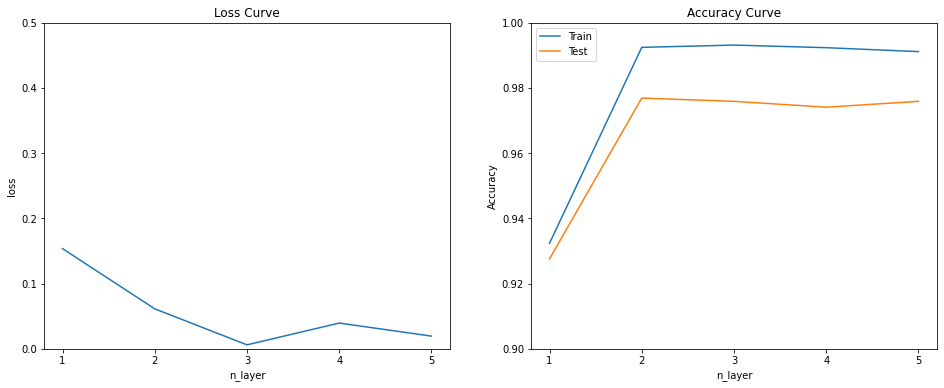

In [ ]:
train_loss = []
train_acc  = []
test_acc   = []

for n_layer, hist in zip(n_layers, hists):
    train_loss.append(hist['loss'][-1])
    train_acc.append(hist['acc_train'][-1])
    test_acc.append(hist['acc_test'][-1])

plt.subplots(ncols=2, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(n_layers, train_loss)
plt.ylim(0.0, 0.5)
_ = plt.xticks(n_layers, n_layers)
plt.xlabel("n_layer")
plt.ylabel("loss")
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(n_layers, train_acc, label="Train")
plt.plot(n_layers, test_acc, label="Test")
plt.ylim(0.9, 1.0)
_ = plt.xticks(n_layers, n_layers)
plt.xlabel("n_layer")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

# Q2

In [ ]:
n_hiddens = [1, 4, 16, 64]
hists = []

for n_hidden in n_hiddens:
    model = create_model(2, 784, 10, n_hidden)
    model = model.to(device) 

    print(f"n_hidden: {n_hidden}")
    hist = train(model, data_train, data_test, num_epochs=10)
    hists.append(hist)
    
    print()

n_hidden: 1
Epoch: 1, Training Loss: 1.8370, Training Accuracy: 0.2515, Test Accuracy: 0.2432
Epoch: 2, Training Loss: 1.8135, Training Accuracy: 0.3198, Test Accuracy: 0.3163
Epoch: 3, Training Loss: 1.6719, Training Accuracy: 0.3529, Test Accuracy: 0.3493
Epoch: 4, Training Loss: 1.7547, Training Accuracy: 0.3718, Test Accuracy: 0.3640
Epoch: 5, Training Loss: 1.6707, Training Accuracy: 0.3820, Test Accuracy: 0.3763
Epoch: 6, Training Loss: 1.6870, Training Accuracy: 0.3911, Test Accuracy: 0.3824
Epoch: 7, Training Loss: 1.4662, Training Accuracy: 0.3974, Test Accuracy: 0.3898
Epoch: 8, Training Loss: 1.4664, Training Accuracy: 0.3967, Test Accuracy: 0.3925
Epoch: 9, Training Loss: 1.3862, Training Accuracy: 0.3990, Test Accuracy: 0.3941
Epoch: 10, Training Loss: 1.4565, Training Accuracy: 0.4006, Test Accuracy: 0.3956

n_hidden: 4
Epoch: 1, Training Loss: 0.5371, Training Accuracy: 0.7998, Test Accuracy: 0.8027
Epoch: 2, Training Loss: 0.9958, Training Accuracy: 0.8242, Test Accurac

Text(0.5, 1.0, 'Accuracy Curve')

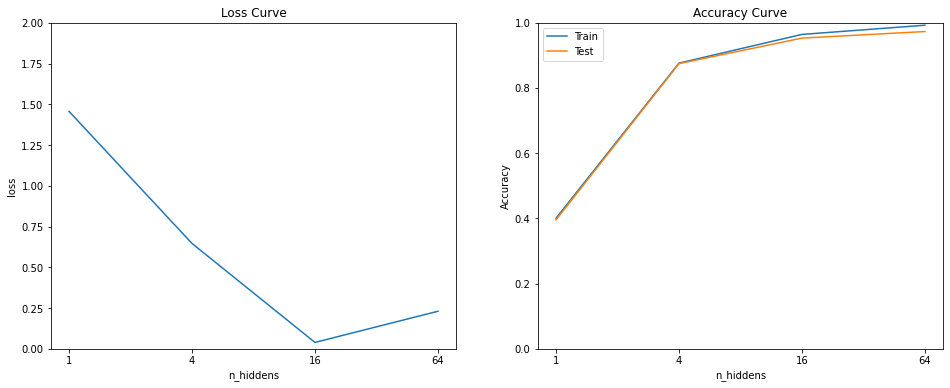

In [ ]:
train_loss = []
train_acc  = []
test_acc   = []

for n_hidden, hist in zip(n_hiddens, hists):
    train_loss.append(hist['loss'][-1])
    train_acc.append(hist['acc_train'][-1])
    test_acc.append(hist['acc_test'][-1])

plt.subplots(ncols=2, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss)
plt.ylim(0.0, 2.0)
_ = plt.xticks(np.arange(len(n_hiddens)), n_hiddens)
plt.xlabel("n_hiddens")
plt.ylabel("loss")
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train")
plt.plot(test_acc, label="Test")
plt.ylim(0.0, 1.0)
_ = plt.xticks(np.arange(len(n_hiddens)), n_hiddens)
plt.xlabel("n_hiddens")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

# Q3

In [ ]:
model = create_model(2, 784, 10, 64, activation=None)
model = model.to(device)
hist = train(model, data_train, data_test, num_epochs=10)

Epoch: 1, Training Loss: 0.5386, Training Accuracy: 0.9196, Test Accuracy: 0.9207
Epoch: 2, Training Loss: 0.5152, Training Accuracy: 0.9275, Test Accuracy: 0.9249
Epoch: 3, Training Loss: 0.4480, Training Accuracy: 0.9271, Test Accuracy: 0.9210
Epoch: 4, Training Loss: 0.4435, Training Accuracy: 0.9197, Test Accuracy: 0.9133
Epoch: 5, Training Loss: 0.1276, Training Accuracy: 0.9258, Test Accuracy: 0.9216
Epoch: 6, Training Loss: 0.2795, Training Accuracy: 0.9261, Test Accuracy: 0.9222
Epoch: 7, Training Loss: 0.2766, Training Accuracy: 0.9282, Test Accuracy: 0.9217
Epoch: 8, Training Loss: 0.0791, Training Accuracy: 0.9275, Test Accuracy: 0.9220
Epoch: 9, Training Loss: 0.3733, Training Accuracy: 0.9333, Test Accuracy: 0.9255
Epoch: 10, Training Loss: 0.0646, Training Accuracy: 0.9309, Test Accuracy: 0.9233


Text(0.5, 1.0, 'Accuracy Curve')

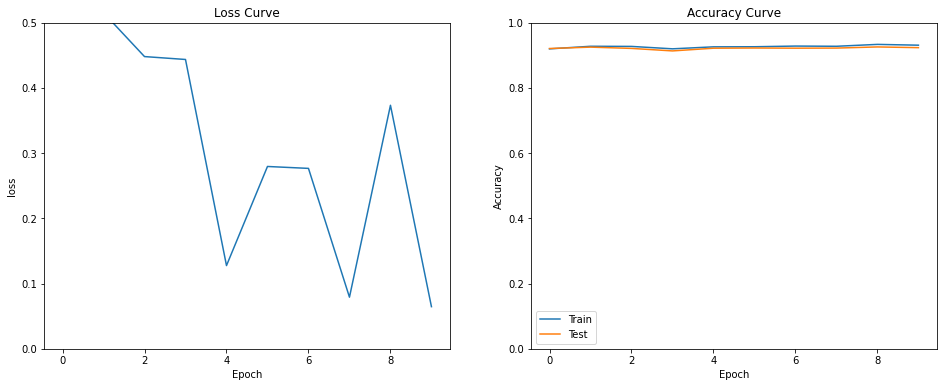

In [ ]:
plt.subplots(ncols=2, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(hist["loss"])
plt.ylim(0.0, 0.5)
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(hist["acc_train"], label="Train")
plt.plot(hist["acc_test"], label="Test")
plt.ylim(0.0, 1.0)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

# Q4

1. 随着网络层数的增长，训练集上的损失不断降低同时训练集合测试集上的准确率不断提高。
2. 固定层数提高隐层单元数时，随着隐层单元数的增加，训练集上的损失不断降低同时训练集合测试集上的准确率不断提高。
3. 删掉激活函数后，网络的损失函数以及准确率在训练过程中基本保持不变，且最终模型性能接近于单层的网络。
4. 增加模型的层数或者隐层的单元数会提高模型的表达能力，因此模型的准确率会不断提高。而如果删除了隐层的激活函数，此时每一层都只是一个线性变换因此组合之后仍是一个线性变换，此时的神经网络相当于一个线性回归无法处理非线性的问题，因此模型的最终性能接近于单层网络。